# House Prices : EDA and ensemble regression
### **Yassine Ghouzam, PhD**
#### 12/08/2017

* **1 Introduction**
* **2 Load and check data**
    * 2.1 load data
    * 2.2 Removing outliers
* **3 SalePrice analysis**
    * 3.1 SalePrice exploratory analysis
* **4 Filling missing Values**    
    * 4.1 Imputing missing values
* **5 Feature transformation/engineering**
    * 5.1 Categorical values
        * 5.1.1 Ordered
        * 5.1.2 Non Ordered
    * 5.2 Numerical values
        * 5.2.1 Reduce skewness (Log transformation)
    * 5.3 Normalisation
    * 5.4 Missing LotFrontage prediction
* **6 Modeling**
    * 6.1 Linear regression models
        * 6.1.1 Cross validate models
        * 6.1.2 Features coefficients
    * 6.2 Tree based modeling
        * 6.2.1 Cross validate models
        * 6.2.2 Features importance
    * 6.3 Prediction
        * 6.3.1 Plot learning curves
        * 6.3.2 Combining prediction and submition
    

## 1. Introduction

## Don't worry there is no Game Of Thrones spoilers here, so you can keep reading safely :p

This is a kernel combining data exploration analysis and ensemble modeling for house price prediction. So if you plan to buy or sell an house soon, it is highly recommended to read it :p.

The House prices is the perfect competition to introduce to regression techniques and data tranformation. Firstly, I will display some feature analysis then ill focus on feature transformation/engineering. Last part concerns modeling and prediction of houses prices using an ensemble procedure. 

This script follows four main parts:

* **Data correction**
* **SalePrice analysis**
* **Feature engineering**
* **Modeling**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

%matplotlib inline
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
import xgboost as xgb
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')

sns.set(style='white', context='notebook', palette='deep')

C:\Users\yassine\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 2. Load and check data
### 2.1 Load data

In [3]:
# Load data
##### Load train and Test set
train = pd.read_csv("I:/yassine/Documents/MOOC/test/House_price/train.csv")
test = pd.read_csv("I:/yassine/Documents/MOOC/test/House_price/test.csv")

In [4]:
train.shape

(1460, 81)

In [5]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


The train set is composed of 81 columns,so we will not explore all features but focus on most important ones.

Moreover, after encoding of categorical values, the number of columns will explode, so it will be wise to choose regression methods that make automatically feature selection. 

In [6]:
# Which types of features
# 37 features
train.select_dtypes(include=['int64','float64']).columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [7]:
# 43 features
train.select_dtypes(include=['object']).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

We have 37 numerical features and 43 categorical features. **Since we have a lot of categorical features and a regression problem, we have to pay attention to multicolinearities after the categorical encoding.**

**Somes of these numerical features are actually categorical (MoSold,YrSold and MSSubClass). We will treat them in the section 5**

In [8]:
train = train.drop(labels = ["Id"],axis = 1)
test = test.drop(labels = ["Id"],axis = 1)

We don't need 'Id' feature, so we drop it.

In [9]:
def multiplot(data,features,plottype,nrows,ncols,figsize,y=None,colorize=False):
    """ This function draw a multi plot for 3 types of plots ["regplot","distplot","coutplot"]"""
    n = 0
    plt.figure(1)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    if colorize:
        colors = sns.color_palette(n_colors=(nrows*ncols))
    else :
        colors = [None]*(nrows*ncols)
        
    for row in range(ncols):
        for col in range(nrows):
            
            if plottype == 'regplot':
                if y == None:
                    raise ValueError('y value is needed with regplot type')
                
                sns.regplot(data = data, x = features[n], y = y ,ax=axes[row,col], color = colors[n])
                correlation = np.corrcoef(data[features[n]],data[y])[0,1]
                axes[row,col].set_title("Correlation {:.2f}".format(correlation))
            
            elif plottype == 'distplot':
                sns.distplot(a = data[features[n]],ax = axes[row,col],color=colors[n])
                skewness = data[features[n]].skew()
                axes[row,col].legend(["Skew : {:.2f}".format(skewness)])
            
            elif plottype in ['countplot']:
                g = sns.countplot(x = data[features[n]], y = y, ax = axes[row,col],color = colors[n])
                g = plt.setp(g.get_xticklabels(), rotation=45)
                
            n += 1
    plt.tight_layout()
    plt.show()
    plt.gcf().clear()

I defined this function to easily plot multiple figures of the same type.

### 2.2 Removing outliers

Classifications problems are generally very robust to outliers. However, outliers can be very problematic for regression problems. So we need to find and remove them.

Let's explore the data.

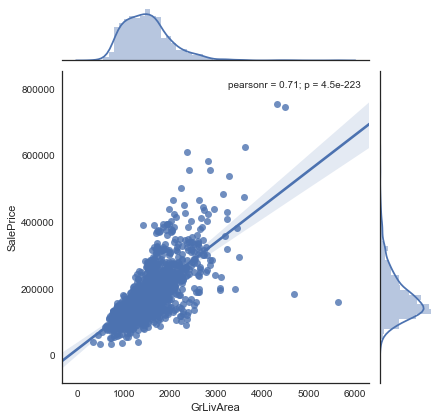

In [10]:
g = sns.jointplot(x = train['GrLivArea'], y = train['SalePrice'],kind="reg")

An outlier is an observation that lies an abnormal distance from other values in a random sample from a population.

Here, we can see two points, at the bottom right, corresponding to this definition. They have extremely large GrLivArea value with a low price. These two points behave very differently from the others. These two point are definitly outliers !

In [11]:
# Remove outliers manually (Two points in the bottom right)
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index).reset_index(drop=True)

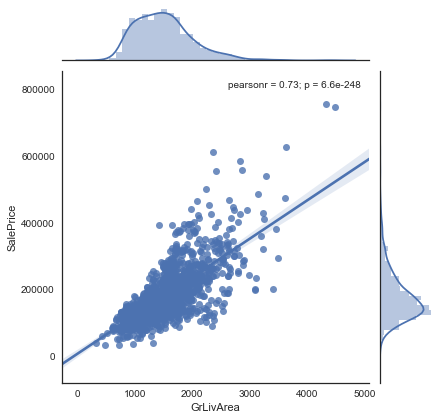

In [12]:
g = sns.jointplot(x = train['GrLivArea'], y = train['SalePrice'],kind="reg")

When we remove these two points, we notice that the relation between SalePrice and GrLivArea is better discribed. We have a pearson correlation of 0.73 between the two features.


Be carrefull, removing outliers may affect badly our models if ever there were also outliers in the test data. 

I have tried to remove many outliers from SalePrice, GrLivArea, LotArea threshold ... but my attempts has negatively impacted the score (Public leaderboard score) 

Instead of removing all outliers, i prefered to manage them by making my models robust on them (see section 5.3 Normalisation).

## 3. SalePrice analysis
### 3.1 SalePrice exploratory analysis

In [13]:
train['SalePrice'].describe()

count      1458.000000
mean     180932.919067
std       79495.055285
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

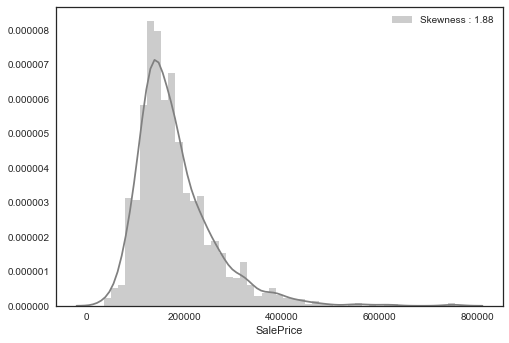

In [14]:
g = sns.distplot(train['SalePrice'],color="gray")
g = g.legend(['Skewness : {:.2f}'.format(train['SalePrice'].skew())],loc='best')

SalePrice is our target variable. 
The SalePrice feature has a positive skewness (right skewed). Since linear models usually perform better on normally distributed data, we need to transform this distribution to a normal one.

To adress this problem we can use a log transformation (see section 5.2 Numerical values).

The mean price is 180 932 dollars (i suppose). The standard deviation is 79 495 dollars.

Let's explore the correlated features.

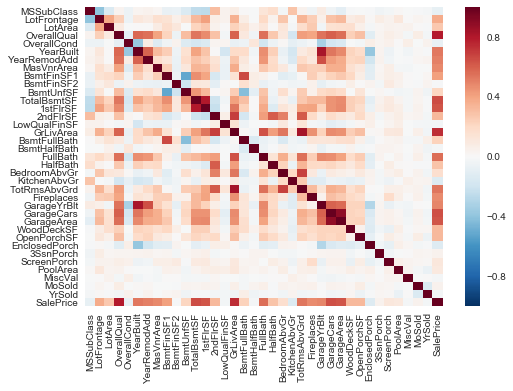

In [15]:
corrmat = train.corr()
g = sns.heatmap(train.corr())

The house price (SalePrice) shows a strong positive correlation with the Overall house quality (OverallQual), the Ground living area (GrLivArea), the 1st floor area (1stFlrSF) , the basement area (TotalBsmtSF) and the Size of garage (GarageCars, GarageArea).

Let's see in details the most correlated features.

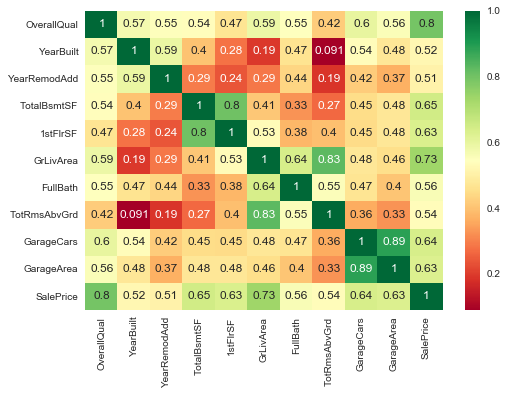

In [16]:
# most correlated features
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Here i show the heatmap of the top correlated features with SalePrice (abs(x) > 0.5).

As i said before, the OverallQual feature is very strongly correlated (0.8)! 

GarageCars and GarageAre are also strongly correated with SalePrice. But it these two features are more or less similar (correlation 0.89).

Let's explore the relationship between the top correlated feature with SalePrice.

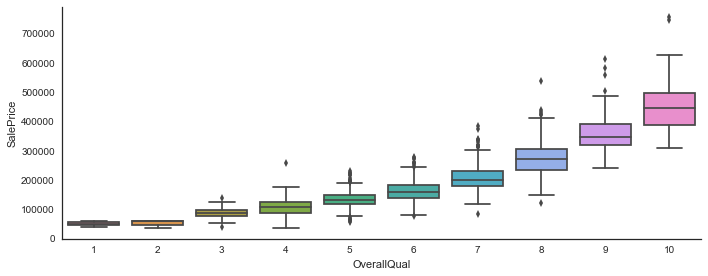

In [17]:
g = sns.factorplot(x="OverallQual",y="SalePrice",data=train,kind='box',aspect=2.5)

Let's begin with the most correlated feature, OverallQual. 

This feature show a quasi-perfect relation with the SalePrice. SalePrice is always growing up with the Overall Quality of the house. 

Let's see the other features.

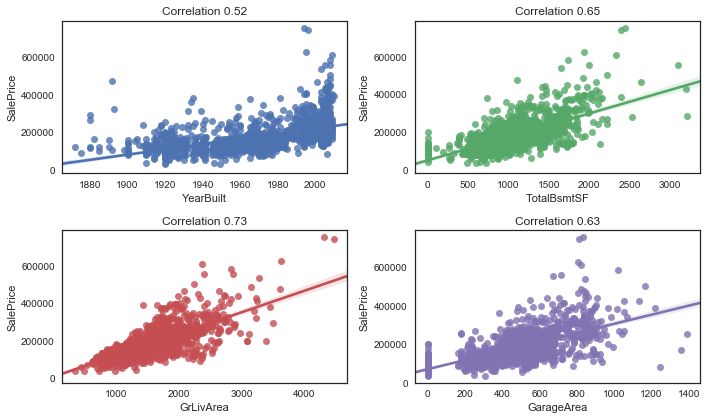

In [18]:
feats = ["YearBuilt","TotalBsmtSF","GrLivArea","GarageArea"]

multiplot(data = train,features = feats,plottype = "regplot",nrows = 2, ncols = 2,
          figsize = (10,6),y = "SalePrice", colorize = True)

These features seems to have a linear relation with the SalePrice.

## 4. Filling missing Values
### 4.1 Imputing missing values

In [19]:
## Join train and test datasets in order to avoid obtain the same number of feature during categorical conversion
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [20]:
# Infos
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 80 columns):
1stFlrSF         2917 non-null int64
2ndFlrSF         2917 non-null int64
3SsnPorch        2917 non-null int64
Alley            198 non-null object
BedroomAbvGr     2917 non-null int64
BldgType         2917 non-null object
BsmtCond         2835 non-null object
BsmtExposure     2835 non-null object
BsmtFinSF1       2916 non-null float64
BsmtFinSF2       2916 non-null float64
BsmtFinType1     2838 non-null object
BsmtFinType2     2837 non-null object
BsmtFullBath     2915 non-null float64
BsmtHalfBath     2915 non-null float64
BsmtQual         2836 non-null object
BsmtUnfSF        2916 non-null float64
CentralAir       2917 non-null object
Condition1       2917 non-null object
Condition2       2917 non-null object
Electrical       2916 non-null object
EnclosedPorch    2917 non-null int64
ExterCond        2917 non-null object
ExterQual        2917 non-null object
Exterior1st      291

In [21]:
dataset = dataset.fillna(np.nan)

In [22]:
missing_features = dataset.columns[dataset.isnull().any()]
missing_features

Index(['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'Electrical', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Functional', 'GarageArea', 'GarageCars',
       'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt',
       'KitchenQual', 'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType',
       'MiscFeature', 'PoolQC', 'SalePrice', 'SaleType', 'TotalBsmtSF',
       'Utilities'],
      dtype='object')

In [23]:
dataset[missing_features].isnull().sum()

Alley           2719
BsmtCond          82
BsmtExposure      82
BsmtFinSF1         1
BsmtFinSF2         1
BsmtFinType1      79
BsmtFinType2      80
BsmtFullBath       2
BsmtHalfBath       2
BsmtQual          81
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
Fence           2346
FireplaceQu     1420
Functional         2
GarageArea         1
GarageCars         1
GarageCond       159
GarageFinish     159
GarageQual       159
GarageType       157
GarageYrBlt      159
KitchenQual        1
LotFrontage      486
MSZoning           4
MasVnrArea        23
MasVnrType        24
MiscFeature     2812
PoolQC          2908
SalePrice       1459
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

At first glance, it appears that we will have a lot of work to deal with missing values. 

But don't worry, after reading carrefully the data_description.txt file attached, most of the missing values correponds to None values, they aren't missing value.

For most of these missing values, it appears that the NA correspond to the absence of the feature, so actually it is an information (for example , a house that doesn't have an Alley access, a Pool or a Fence ...).

Except for some features (LotFrontage espacially), all we need is to rename the NA category to 'None' or 'No' (in my case).

In [24]:
# Treat NaN values
dataset["Alley"] = dataset["Alley"].fillna("No")

dataset["MiscFeature"] = dataset["MiscFeature"].fillna("No")

dataset["Fence"] = dataset["Fence"].fillna("No")

dataset["PoolQC"] = dataset["PoolQC"].fillna("No")

dataset["FireplaceQu"] = dataset["FireplaceQu"].fillna("No")

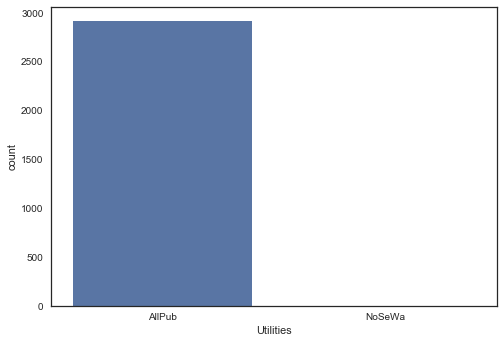

In [25]:
g = sns.countplot(dataset["Utilities"])

Since there is no "NA" category in the Utilities feature, i prefered to fill the missing 2 values by the most common values rather than deleting the two rows (Information is precious ! Think we have only 1459 train rows for 1460 predictions to do ! 

In [26]:
dataset["Utilities"] = dataset["Utilities"].fillna("AllPub")

In [27]:
dataset["BsmtCond"] = dataset["BsmtCond"].fillna("No")
dataset["BsmtQual"] = dataset["BsmtQual"].fillna("No")
dataset["BsmtFinType2"] = dataset["BsmtFinType2"].fillna("No")
dataset["BsmtFinType1"] = dataset["BsmtFinType1"].fillna("No")
dataset.loc[dataset["BsmtCond"] == "No","BsmtUnfSF"] = 0
dataset.loc[dataset["BsmtFinType1"] == "No","BsmtFinSF1"] = 0
dataset.loc[dataset["BsmtFinType2"] == "No","BsmtFinSF2"] = 0
dataset.loc[dataset["BsmtQual"] == "No","TotalBsmtSF"] = 0
dataset.loc[dataset["BsmtCond"] == "No","BsmtHalfBath"] = 0
dataset.loc[dataset["BsmtCond"] == "No","BsmtFullBath"] = 0
dataset["BsmtExposure"] = dataset["BsmtExposure"].fillna("No")

For Basement features, we will be a little bit smarter. We will set to 0 the basement sizes of houses that haven't basements.  Logical ! :p

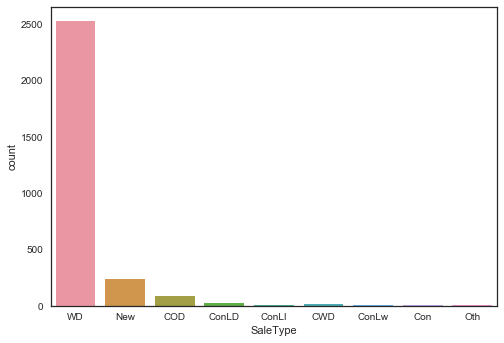

In [28]:
g = sns.countplot(dataset["SaleType"])

dataset["SaleType"] = dataset["SaleType"].fillna("WD")

Rows are precious for House price prediction! So fill the one SaleType missing value with the most common value of SaleType.

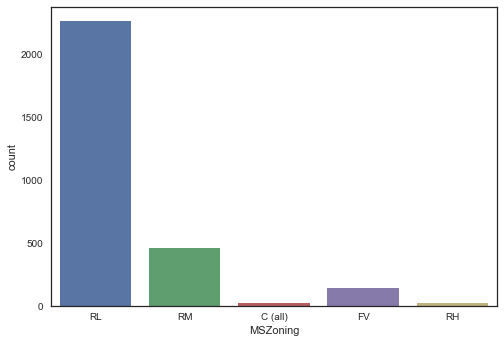

In [29]:
g = sns.countplot(dataset["MSZoning"])

dataset["MSZoning"] = dataset["MSZoning"].fillna("RL")

Here also ! (4 missing values)

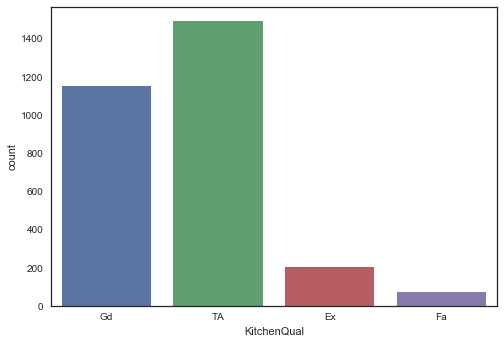

In [30]:
g = sns.countplot(dataset["KitchenQual"])

dataset["KitchenQual"] = dataset["KitchenQual"].fillna("TA")

And ..... here also ! (1 missing value)

In [31]:
dataset["GarageType"] = dataset["GarageType"].fillna("No")
dataset["GarageFinish"] = dataset["GarageFinish"].fillna("No")
dataset["GarageQual"] = dataset["GarageQual"].fillna("No")
dataset["GarageCond"] = dataset["GarageCond"].fillna("No")
dataset.loc[dataset["GarageType"] == "No","GarageYrBlt"] = dataset["YearBuilt"][dataset["GarageType"]=="No"]
dataset.loc[dataset["GarageType"] == "No","GarageCars"] = 0
dataset.loc[dataset["GarageType"] == "No","GarageArea"] = 0
dataset["GarageArea"] = dataset["GarageArea"].fillna(dataset["GarageArea"].median())
dataset["GarageCars"] = dataset["GarageCars"].fillna(dataset["GarageCars"].median())
dataset["GarageYrBlt"] = dataset["GarageYrBlt"].fillna(dataset["GarageYrBlt"].median())

As i did for the Basement features with an extraordinary logical thinking :p , i'll set the Garage Sizes to 0, for houses without garage.

What about the Garage house built date for the houses without garage ?! We could set them to 0. Then the garage could have  been the property of Jesus !! :p resulting in a problem in our data with two distributions, one centered on 0 and an other one in the mean of the real garage years built.

So i choosed to set the garage house built date to the year of the house construction for the houses without garage.

For the rest of the missing values (i.e Houses with a garage and missing GarageArea,GarageCars and GarageYrBlt values), i fill them to the median value of each category.

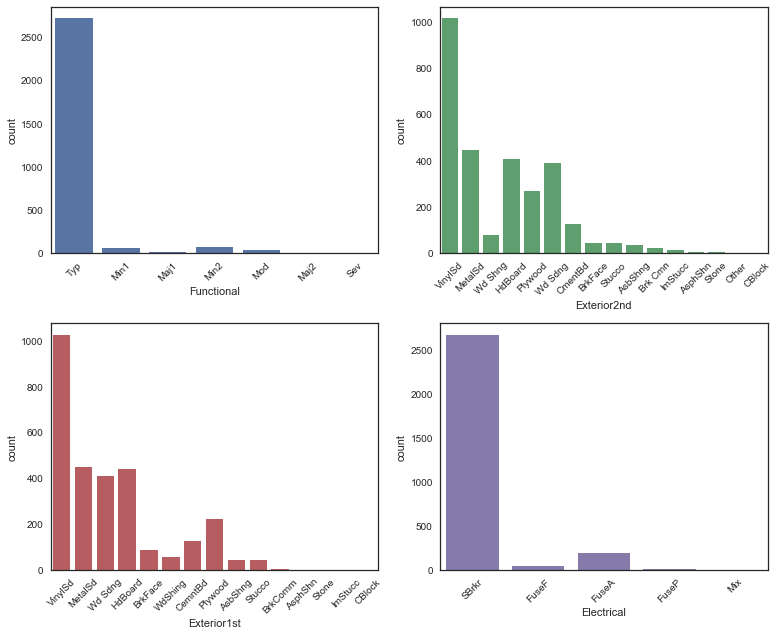

In [32]:
Function_feat = ["Functional","Exterior2nd","Exterior1st","Electrical"]

multiplot(data = dataset ,features = Function_feat,plottype = "countplot",nrows = 2, ncols = 2,
          figsize = (11,9), colorize = True)


dataset["Functional"] = dataset["Functional"].fillna("Typ")
dataset["Exterior2nd"] = dataset["Exterior2nd"].fillna("VinylSd")
dataset["Exterior1st"] = dataset["Exterior1st"].fillna("VinylSd")
dataset["Electrical"] = dataset["Electrical"].fillna("SBrkr")

Again here, i set these missing values with the most common values.

In [33]:
dataset["MasVnrType"] = dataset["MasVnrType"].fillna("None")
dataset.loc[dataset["MasVnrType"] == "None","MasVnrArea"] = 0

## 5. Feature transformation/engineering
### 5.1 Categorical values

Do you remember ? Of course you do ;)
MSSubClass, MoSold and YrSold you are intruders !!!
What are you doing in the numerical division ?! 

Let's transform these features into categorical features (Thx you data_description.txt)

In [34]:
dataset = dataset.replace({'MSSubClass': {20: 'SubClass_20', 30: 'SubClass_30',40: 'SubClass_40',
45: 'SubClass_45',50: 'SubClass_50',60: 'SubClass_60',70: 'SubClass_70',
75: 'SubClass_75',80: 'SubClass_80',85: 'SubClass_85',90: 'SubClass_90',
120: 'SubClass_120',150: 'SubClass_150',160: 'SubClass_160',180: 'SubClass_180',
190: 'SubClass_190'}})

In [35]:
dataset = dataset.replace({'MoSold': {1: 'Jan', 2: 'Feb',3: 'Mar',
4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sep',10: 'Oct',
11: 'Nov',12: 'Dec'}})

In [36]:
dataset['YrSold'] = dataset['YrSold'].astype(str)

#### 5.1.1 Ordered

Ordered categorical features, for example this kernel is ("Very bad", "Bad", "okay", "Good", "Amazing") need to be encoded as numerical ordered values (0->4 for example).

In [37]:
# Categorical values
# Ordered
dataset["BsmtCond"] = dataset["BsmtCond"].astype("category",categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["BsmtExposure"] = dataset["BsmtExposure"].astype("category",categories=['No','Mn','Av','Gd'],ordered=True).cat.codes
dataset["BsmtFinType1"] = dataset["BsmtFinType1"].astype("category",categories=['No','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],ordered=True).cat.codes
dataset["BsmtFinType2"] = dataset["BsmtFinType2"].astype("category",categories=['No','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],ordered=True).cat.codes
dataset["BsmtQual"] = dataset["BsmtQual"].astype("category",categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["ExterCond"] = dataset["ExterCond"].astype("category",categories=['Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["ExterQual"] = dataset["ExterQual"].astype("category",categories=['Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["Fence"] = dataset["Fence"].astype("category",categories=['No','MnWw','GdWo','MnPrv','GdPrv'],ordered=True).cat.codes
dataset["FireplaceQu"] = dataset["FireplaceQu"].astype("category",categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["Functional"] = dataset["Functional"].astype("category",categories=['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],ordered=True).cat.codes
dataset["GarageCond"] = dataset["GarageCond"].astype("category",categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["GarageFinish"] = dataset["GarageFinish"].astype("category",categories=['No','Unf','RFn','Fin'],ordered=True).cat.codes
dataset["GarageQual"] = dataset["GarageQual"].astype("category",categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["HeatingQC"] = dataset["HeatingQC"].astype("category",categories=['Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["KitchenQual"] = dataset["KitchenQual"].astype("category",categories=['Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["PavedDrive"] = dataset["PavedDrive"].astype("category",categories=['N','P','Y'],ordered=True).cat.codes
dataset["PoolQC"] = dataset["PoolQC"].astype("category",categories=['No','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["Utilities"] = dataset["Utilities"].astype("category",categories=['ELO','NoSeWa','NoSewr','AllPub'],ordered=True).cat.codes


#### 5.1.2 Non ordered

What about non ordered categorical features ? Let's transform them with into dummies variables.

** Since we are working on a regression problem, we have to watch out for multicollinearities. That's why i choosed to set the argument drop_firt=True, to derive n-1 features from a feature with n different categories.**

** This help to reduce the collinearity .**

In [38]:
# non ordered
dataset = pd.get_dummies(dataset,columns=["Alley","BldgType","CentralAir",
"Condition1","Condition2","Electrical","Exterior1st","Exterior2nd","Foundation",
"GarageType","Heating","HouseStyle","LandContour","LandSlope","LotConfig","LotShape",
"MSZoning","MasVnrType","MiscFeature","Neighborhood","RoofMatl","RoofStyle",
"SaleCondition","SaleType","Street","MSSubClass",'MoSold','YrSold'],drop_first=True)

In [39]:
dataset = dataset.drop(labels=['MSSubClass_SubClass_150','Condition2_PosN',
                               'MSSubClass_SubClass_160'],axis = 1)

I have read some very good notebooks here and it appears that these 3 columns tends to overfit the training data. So i choosed to drop them. It slightly increases my LBS :D.

### 5.2 Numerical values
#### 5.2.1 Reduce skewness (Log transformation)

In [40]:
# Feature engineering 
# Log transformations


skewed_features = ["BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","GarageArea","MasVnrArea"
                   ,"TotalBsmtSF","1stFlrSF","2ndFlrSF","3SsnPorch","EnclosedPorch",
                   "GrLivArea","LotArea","LowQualFinSF","OpenPorchSF","PoolArea",
                   "ScreenPorch","WoodDeckSF"]

Here, skewness is our enemy since we gonna work with linear models ( Oh sorry for the spoil :'(  , you know in the last episode of Game of thrones ... okay okay promise i'll shut up :p).

So we need to reduce this skewness, one solution is too use a log transformation.

I choosed the log1p to deal with 0 values.

But first let's see how our numerical features are skewed.

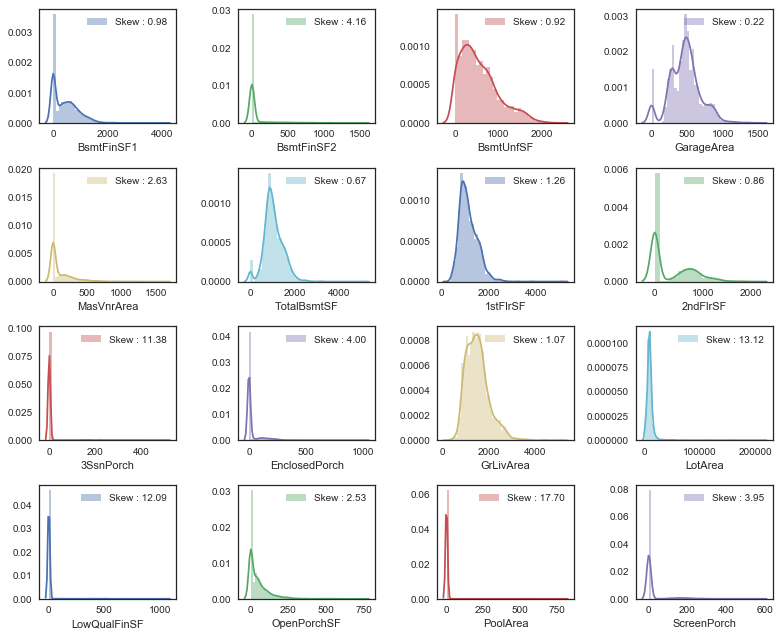

In [41]:
multiplot(data = dataset,features = skewed_features,plottype = "distplot",
          nrows = 4, ncols = 4, figsize = (11,9), colorize = True)

Most of them have a positive skewness.

In [42]:
for feature in skewed_features:
    dataset[feature] = np.log1p(dataset[feature])

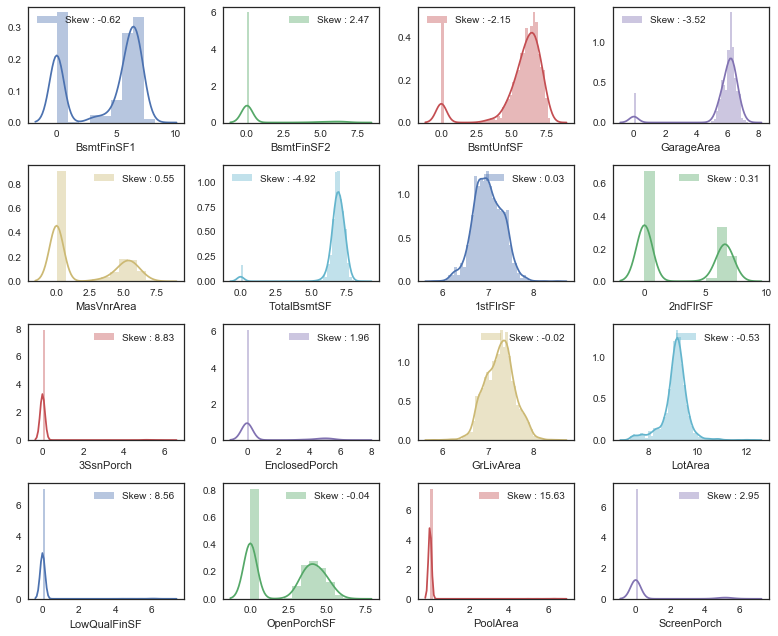

In [43]:
multiplot(data = dataset,features = skewed_features,plottype = "distplot",
          nrows = 4, ncols = 4, figsize = (11,9), colorize = True)

After these log1p transformation, most of our features have a smaller skewness. I think the most important feature to focus on is the GrLivArea since it is strongly correlated with the SalePrice, and for this one the skew is almost 0.

I am sure that this transformation is not optimal, we could have select the most important skewed features and apply the most appropriate transformation. But i wanted to make it simple. 

Nevertheless, the log transformation reduces significantly the rmse of the models.

Let's transform the target feature.

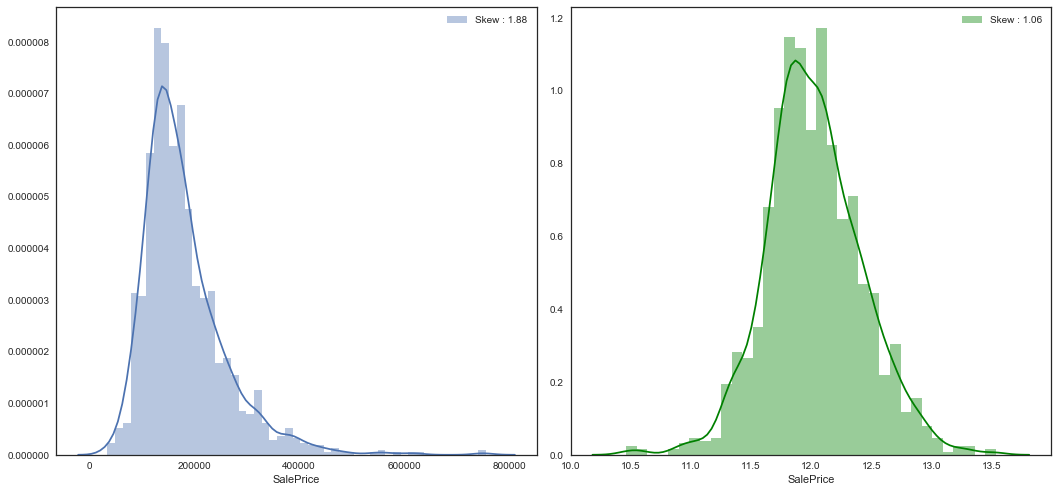

In [44]:
plt.figure(1)
fig, axes = plt.subplots(1,2,figsize=(15,7))

sns.distplot(train["SalePrice"],ax = axes[0])
sns.distplot(np.log1p(train["SalePrice"]),ax = axes[1],color="g")

axes[0].legend(["Skew : {:.2f}".format(train["SalePrice"].skew())])
axes[1].legend(["Skew : {:.2f}".format(np.log1p(train["SalePrice"].skew()))])

plt.tight_layout()
plt.show()
plt.gcf().clear()

This transformation is important! Because it's the target feature. After the transformation, the SalePrice distribution seems to be normal. Good ! :)

In [45]:
dataset["SalePrice"] = np.log1p(dataset["SalePrice"])
Y = dataset["SalePrice"]
dataset = dataset.drop(labels="SalePrice",axis = 1)

### 5.3 Normalisation

Since, we have features with different scales, we need to normalize the data. The log1p transformation already scales the transformed features but there is the other non scaled features such as YearBuilt ect... Moreover it is always safe to normalize the data for a regression problem. 

In [46]:
features = dataset.columns

LotF = dataset["LotFrontage"]
dataset = dataset.drop(labels="LotFrontage",axis= 1)

Among the missing features, there is one that is difficult to manage. The LotFrontage feature has 486 missing values and i choose to predict them. But before i need to normalize the data.

In [47]:
# Normalize data 
#N = Normalizer()
N = RobustScaler()

N.fit(dataset)

dataset = N.transform(dataset)

I choosed the Robustscaler() normalizer to make my models robust to outliers.

### 5.4 Missing LotFrontage prediction

In [48]:
# Predict LotFrontage with other descriptors using a LassoCV Regression model
X_train_LotF = dataset[LotF.notnull()] 
Y_train_LotF = LotF[LotF.notnull()] # Get the LotFrontage non missing values
Y_train_LotF = np.log1p(Y_train_LotF)  # Log transform the data

In [49]:
# Get data to predict (LotFrontage missing)
test_LotF = dataset[LotF.isnull()]

In [50]:
lassocv = LassoCV(eps=1e-8)

cv_results = cross_val_score(lassocv,X_train_LotF,Y_train_LotF,cv=10,scoring="r2",n_jobs=4)
cv_results.mean()# 0.76 ! Very good!

0.76139526086303078

We can predict the LotFrontage missing values with a R^^2 of 0.76 ! Let's do it.

In [51]:
lassocv.fit(X_train_LotF,Y_train_LotF)

LotF_pred = lassocv.predict(test_LotF)

LotF[LotF.isnull()] = LotF_pred

In [52]:
LotF = N.fit_transform(np.array(LotF).reshape(-1,1))

dataset = np.concatenate((dataset,LotF),axis = 1)

Don't forget to normalise the LotFrontage feature.

After, i add it to the normalized dataset.

Congrats !!!! Our dataset is ready for modeling.

## 6. Modeling
### 6.1 Simple modeling

In [53]:
## Separate train dataset and test dataset

X_train = dataset[:train_len]
test = dataset[train_len:]

In [54]:
###### Train classifiers

Y_train = Y[:train_len]

In [55]:
lassocv = LassoCV(eps=1e-7) 
ridge = Ridge(alpha=1e-6) 
lassolarscv = LassoLarsCV()
elasticnetcv = ElasticNetCV(eps=1e-15)

I choosed linear regression techniques. The very good points with theses techniques is that they do automatically the feature selection. No need to remove features. 

#### 6.1.1 Cross validate models

In [56]:
# Regression linear models (Lasso, Ridge, Elasticnet)
def RMSE(estimator,X_train, Y_train, cv=10,n_jobs=4):
    cv_results = cross_val_score(estimator,X_train,Y_train,cv=cv,scoring="neg_mean_squared_error",n_jobs=n_jobs)
    return (np.sqrt(-cv_results)).mean()

I defined this little and very helpfull function to compute the Root mean square error.

In [57]:
RMSE(lassocv, X_train, Y_train)#0.1138

0.11388608138022493

In [58]:
RMSE(ridge, X_train, Y_train)#0.1211

0.12115336039745006

In [59]:
RMSE(lassolarscv, X_train, Y_train)#0.1154

0.11548237092043856

In [60]:
RMSE(elasticnetcv, X_train, Y_train)#0.1140

0.11402603596546479

What the hell ! Who could bielieve that a simple linear regression model performs so well ?! (Im behaving like i just discovered that : WOOOOAAAWW :p) 

The 4 models have very similar scores except for the ridge, if we average their predictions we could probably slightly reduce  the error !

In [61]:
lassocv.fit(X_train,Y_train)
ridge.fit(X_train,Y_train)
lassolarscv.fit(X_train,Y_train)
elasticnetcv.fit(X_train,Y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=1e-15, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

#### 6.1.2 Features coefficients

In [62]:
print("LassoCV regression has conserved %d features over %d"%(len(features[lassocv.coef_!=0]),X_train.shape[1]))
print("Ridge regression has conserved %d features over %d"%(len(features[ridge.coef_!=0]),X_train.shape[1]))
print("LassoLarsCV regression has conserved %d features over %d"%(len(features[lassolarscv.coef_!=0]) ,X_train.shape[1]))
print("ElasticNetCV regression has conserved %d features over %d"%(len(features[elasticnetcv.coef_!=0]),X_train.shape[1]))

LassoCV regression has conserved 141 features over 228
Ridge regression has conserved 228 features over 228
LassoLarsCV regression has conserved 67 features over 228
ElasticNetCV regression has conserved 140 features over 228


So, 3 of these models have selected features. Since our dataset may contains multicollinearies LassoCV LassoLarsCV and ElasticNetCV automatically removed them by regularization. We now understand why ridge has lower performances since it considers all the features for the regression (i don't know why may be because of the parameters i've set).

The funniest part is that in the LassoCV, LassoLarsCV and ElasticNetCV modelsLotFrontage has been skipped. 

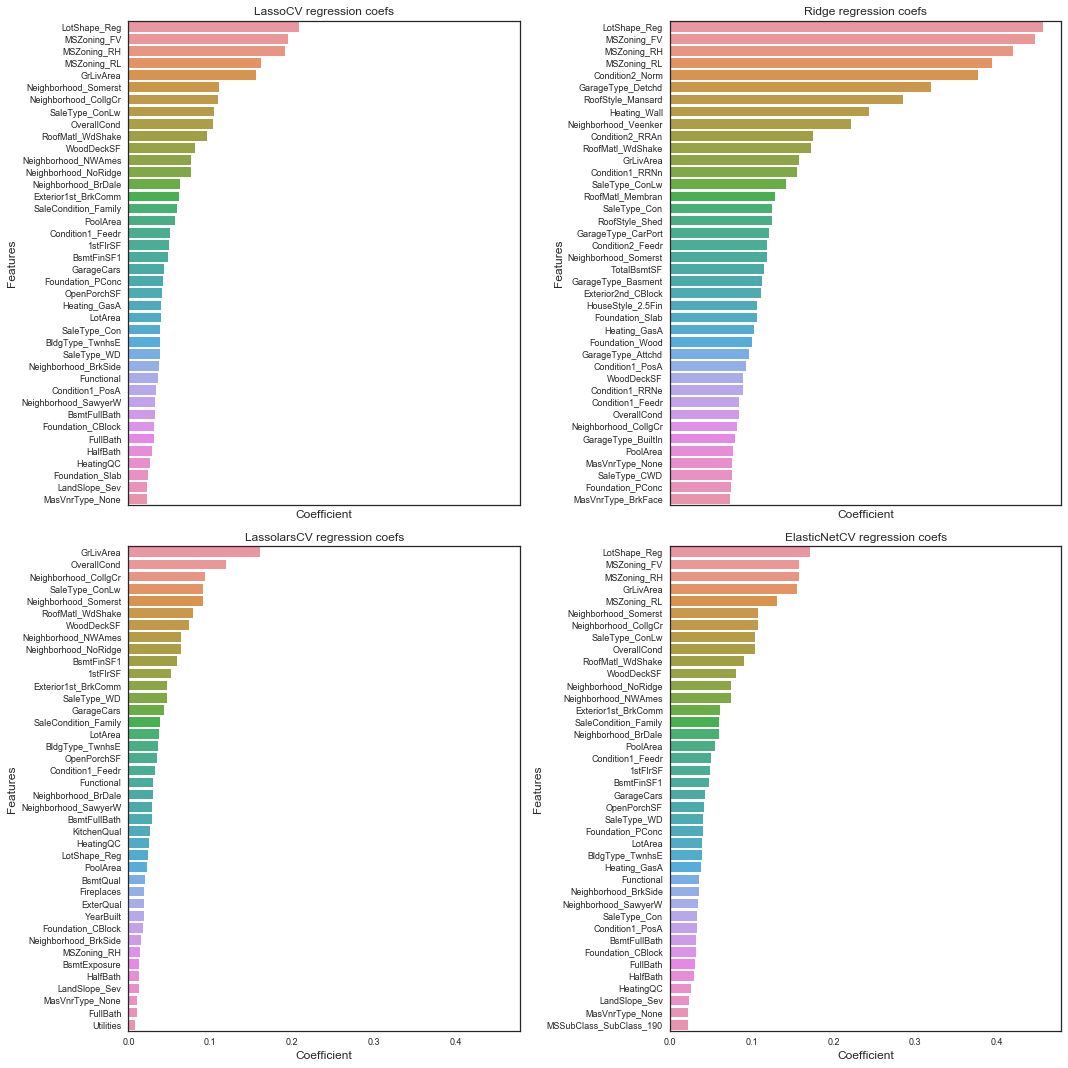

In [63]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_regressors = [("LassoCV", lassocv),("Ridge",ridge),("LassolarsCV",lassolarscv),("ElasticNetCV",elasticnetcv)]

nregressors = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_regressors[nregressors][0]
        regressor = names_regressors[nregressors][1]
        indices = np.argsort(regressor.coef_)[::-1][:40]
        g = sns.barplot(y=features[indices][:40],x = regressor.coef_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Coefficient",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " regression coefs")
        nregressors += 1
plt.tight_layout()
plt.show()
plt.gcf().clear()


Here, the features coefficients (show only top 40 features). It appears that GrLivArea has an important weight in the 4 models.

According to the RMSE scores, i choosed the Lassocv, LassolarsCV and the ElasticNetCV models.

In [64]:
Y_pred_lassocv = np.expm1(lassocv.predict(test))
Y_pred_lassolarscv = np.expm1(lassolarscv.predict(test))
Y_pred_elasticnetcv = np.expm1(elasticnetcv.predict(test))

Don't forget to transform the log1p(SalePrice) to their real values using expm1.

### 6.2 Tree based modeling
#### 6.2.1 Cross validate models

Next i wanted to combine the linear models to tree based models. I'hve tested the random forest it shows bad performances (~0.14 with hyperparameters tunning).

I decided to focus on, the kaggle "darling" algorithm :p XGBoost, the LightGBM and the Gradient Boosting algorithm.

Thanks to the excellent @Serigne kernel, i get near-optimal parameters for these 3 algorithms.

This spare us a lot of hyperparameters tunning :D! 

In [65]:
# XGBoost

#model_xgb = xgb.XGBRegressor(n_estimators=3000, max_depth=2, learning_rate=0.1)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1)

RMSE(model_xgb,X_train,Y_train)#0.128

0.11672692753048997

In [66]:
model_xgb.fit(X_train,Y_train)
Y_pred_xgb = np.expm1(model_xgb.predict(test))

In [67]:
# Gradient Boosting
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
RMSE(GBoost,X_train,Y_train)

0.11261294450427581

In [68]:
GBoost.fit(X_train,Y_train)
Y_pred_GBoost = np.expm1(GBoost.predict(test))

In [69]:
# Light GBM
LightGB = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

RMSE(LightGB,X_train,Y_train)

0.11491602166122709

In [70]:
LightGB.fit(X_train,Y_train)
Y_pred_LightGB = np.expm1(LightGB.predict(test))

#### 6.2.2 Features importance

Let's see now the features importance for these regressors (show only top 40 features).

We are getting close to the end of this kernel and the moment to tell you goodbye  :'(  :'(  :'(

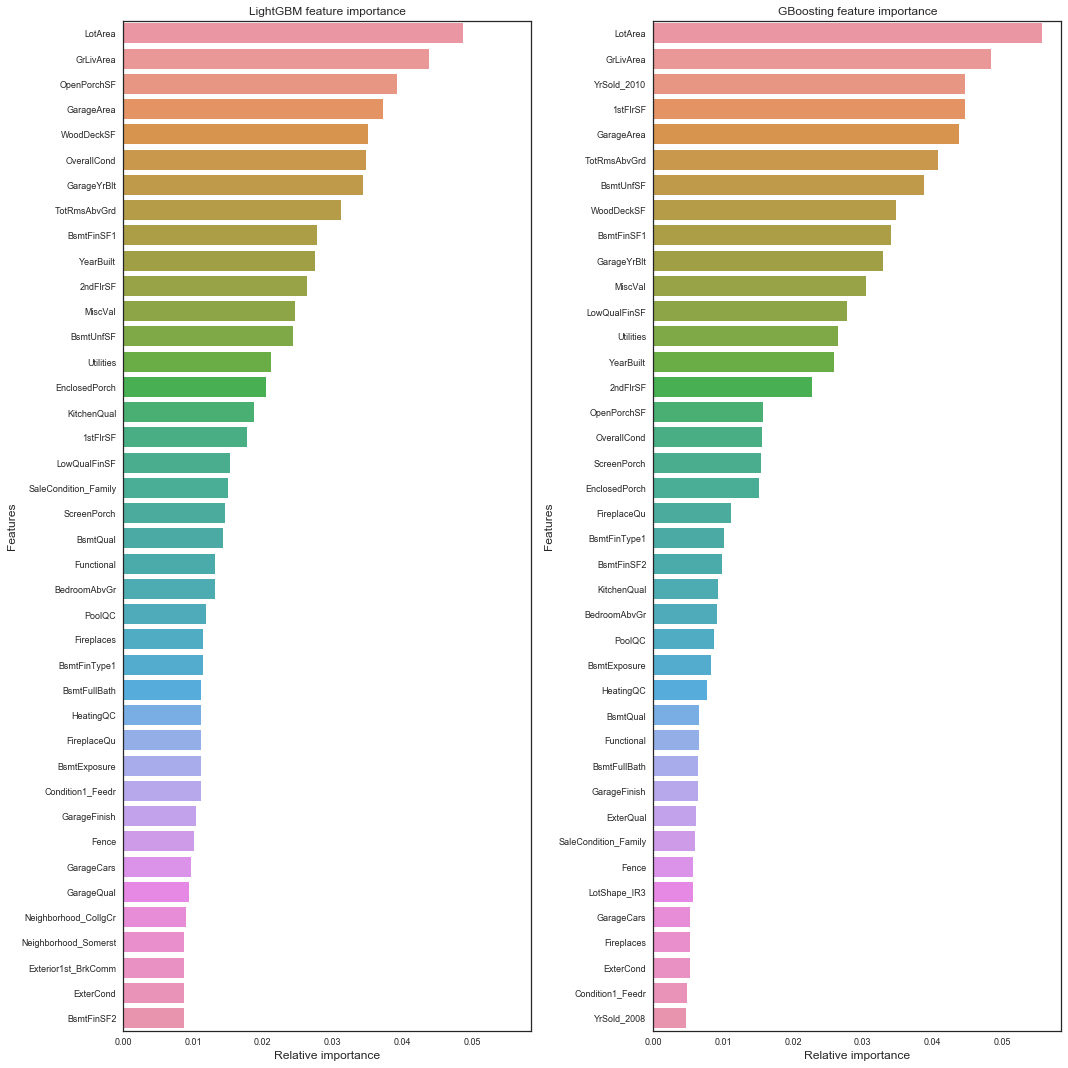

In [ ]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_regressors = [("LightGBM",LightGB),("GBoosting",GBoost)]

nregressors = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_regressors[nregressors][0]
        regressor = names_regressors[nregressors][1]
        indices = np.argsort(regressor.feature_importances_)[::-1][:40]
        g = sns.barplot(y=features[indices][:40],x = regressor.feature_importances_[indices][:40] , orient='h',ax=axes[nregressors])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nregressors += 1

plt.tight_layout()
plt.show()
plt.gcf().clear()

Unfortunatly, i could not plot the feature importance for the XGboost. 

Wooaw I just see on the web that :

model_xgb.booster().get_score(importance_type='weight')

Next time ill try ;)

More seriously , these barplots seems to be in agreement with regression coefficients.  LotArea, GrdLivArea, GarageArea and OverallCond seems to have an important role in the prediction.

The 6 regressors have different top features according to the relative importance. It means that their predictions are not based on the same features. Nevertheless, they share some common important features for the regression , for example LotArea, GrdLivArea, GarageArea and OverallCond.

Still no LotFrontage in the top features :'( :'(

### 6.3 Prediction 
#### 6.3.1 Plot learning curves

Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy.

In [ ]:
def plot_learning_curves(estimators, titles, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    nrows = len(estimators)//2
    ncols = (len(estimators)//nrows)+ (0 if len(estimators) % nrows == 0 else 1)
    plt.figure(1)
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    
    n = 0
    for col in range(ncols):
        for row in range(nrows):
            estimator = estimators[n]
            title = titles[n]
            axes[row,col].set_title(title)
            
            if ylim is not None:
                axes[row,col].set_ylim(*ylim)
            
            axes[row,col].set_xlabel("Training examples")
            axes[row,col].set_ylabel("Score")
            
            train_sizes, train_scores, test_scores = learning_curve(estimator,
                    X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
                    scoring="neg_mean_squared_error")
    
            train_scores = np.sqrt(-train_scores)
            test_scores = np.sqrt(-test_scores)
    
            train_scores_mean = np.mean(train_scores, axis=1)
            train_scores_std = np.std(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            test_scores_std = np.std(test_scores, axis=1)
            axes[row,col].grid()
        
            axes[row,col].fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
            axes[row,col].fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
            axes[row,col].plot(train_sizes, train_scores_mean, 'o-', color="r",
                     label="Training score")
            axes[row,col].plot(train_sizes, test_scores_mean, 'o-', color="g",
                     label="Cross-validation score")
            axes[row,col].legend(loc="best")
            
            n += 1
    plt.tight_layout()
    plt.show()
    plt.gcf().clear()

    

estimators = [lassocv,lassolarscv,elasticnetcv,GBoost,LightGB,model_xgb]
titles = ["LassoCV","LassoLarsCV","ElasticNet","Gradient Boosting","Light GBM","Xgboost"]

plot_learning_curves(estimators, titles, X_train, Y_train, cv=2 ,n_jobs=4)



XGboost regressor tend to overfit the training set. According to the decreasing cross-validation curves all these regressors could perform better with more training examples.

LassoCV , LassoLarsCV and ElasticNetCV regressors seem to better generalize the prediction since the training and cross-validation curves are close together.


#### 6.3.2 Combining predictions and submition

In [ ]:
#Submission
results = pd.read_csv("I:/yassine/Documents/MOOC/test/House_price/sample_submission.csv")

results["SalePrice"] = ((Y_pred_lassocv*0.4 + Y_pred_elasticnetcv*0.3 + Y_pred_lassolarscv*0.3))*0.4 + Y_pred_xgb*0.2 + Y_pred_GBoost*0.2 + Y_pred_LightGB*0.2

results.to_csv("xgb_linear_python_outliers3.csv",index=False)

Now we combine the different prediction. I set the weights according to the RMSE scores.

With all this work, i ranked in the top 12% with 0.11716 LBS.

I give you some others ideas i didnt try, that could increase your performance :
    - Strong Feature engineering (I'hve tested some but it seems that i had more collinearity)
    - Adding external data
    - Try KRR/SVR
    - Passive Aggressive Regression
    - and moreee
    
    


**That's all my friends :)**

**I really enjoyed writing this kernel, and explain it. So if you it is helpful for you (i hope) or you liked it (i hope too), some upvotes would be very much appreciated - That will keep me motivated :)**


So ? 
As i told you, no GOT spoilers here :p